# Sweet Lift Taxi ¿Cuántos taxis se necesitaran en la siguiente hora?

## Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

### EDA

In [1]:
# Inicialización de librerías
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Cargar el dataframe de taxis
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
# Visualizar las primeras filas
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Verificar los tipos de dato, valores ausentes, número de observaciones
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
# Estádistica descriptiva
df_taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
# Verificar que las fechas esten en orden cronológico
df_taxi.index.is_monotonic_increasing

True

In [7]:
# Verificar que no existan duplicados
df_taxi.index.duplicated().sum()

0

In [8]:
# Ver las fechas de inicio y fin 
print('Fecha inicial:',df_taxi.index.min())
print('Fecha final:', df_taxi.index.max())

Fecha inicial: 2018-03-01 00:00:00
Fecha final: 2018-08-31 23:50:00


**Nota:** 
- Existen 26496 datos.
- No hay valores ausentes ni duplicados.
- Todos del 2018. Desde marzo hasta agusto.
- Las ordenes van de 0 a 119. 
- Existen valores atípicos en la columna num_orders.
- Es un problema de regresión. 
- Formato de la fecha (año, mes, día)

### Remuestreo por hora

In [9]:
# Remuestreo por hora 
df_taxi = df_taxi.resample('1H').sum()

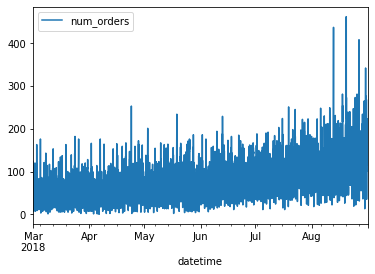

In [10]:
# Visualizar los datos
df_taxi.plot()
plt.show()

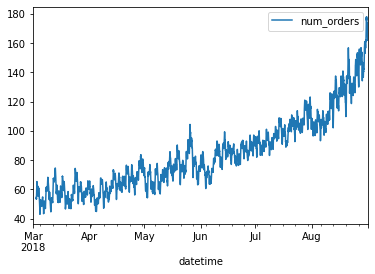

In [11]:
# Visualizar la media móvil 
df_taxi.rolling(40).mean().plot()
plt.show()

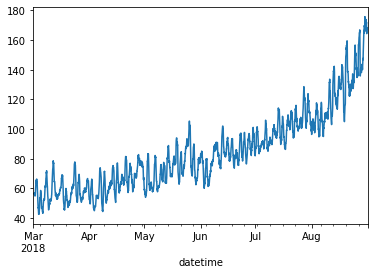

In [12]:
# Descomponer los datos
decomposed = seasonal_decompose(df_taxi)

# Visualizar la tendencia
decomposed.trend.plot()
plt.show()

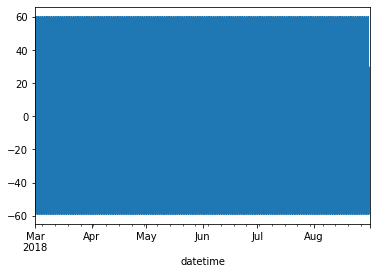

In [13]:
# Visualiar seasonal
decomposed.seasonal.plot()
plt.show()

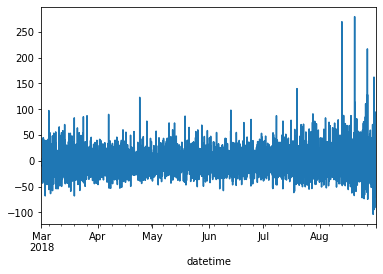

In [14]:
# Visualiar el residuo
decomposed.resid.plot()
plt.show()

**Nota:**
- Hay una tendencia clara positiva.
- Se reemplazara la media móvil por la tendencia.
- Se agregara seasonal como característica.

### Feature engineering

In [15]:
def make_features(df, max_lag):

    '''
    Crea nuevas características a partir de un dataframe con index del tipo datetime.
    Crea las columnas year, month, day y day of week. Agrega n características de desfase
    de acuerdo a la variable max_lag. Agrega una columna de tendencia y otra estacional.
    in: dataframe con index datetime.
    out: dataframe con las características agregadas.
    '''
    # Separar el año, día, mes y día de la semana en columnas diferentes
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek   

    # Características de desfase
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)

    # Característica de tendencia
    df['trending'] = seasonal_decompose(df['num_orders']).trend.shift()

    # Caracteristica estacional
    df['seasonal'] = seasonal_decompose(df['num_orders']).seasonal.shift()

In [16]:
# Agregar las nuevas carcterísticas al dataframe
# 60 Desfases
make_features(df_taxi, 60)
# Visualizar el dataframe creado
df_taxi

,num_orders,year,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,trending,seasonal
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.248112
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.177074
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.982743
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.885407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,196.0,135.0,167.0,179.0,183.0,143.0,163.0,60.0,NaN,-15.527958
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,163.0,196.0,135.0,167.0,179.0,183.0,143.0,163.0,NaN,-7.124270
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,220.0,163.0,196.0,135.0,167.0,179.0,183.0,143.0,NaN,-2.696560


## Dividir el conjunto en entrenamiento y prueba

In [17]:
# Dividir el dataframe en entrenamiento y prueba 
train, test = train_test_split(df_taxi, test_size=0.1, shuffle=False)

# Eliminar las filas con valores ausentes
train.dropna(inplace=True) 
test.dropna(inplace=True)

# Dividir las características y el objetivo
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

/tmp/ipykernel_27/2687462172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.dropna(inplace=True)
/tmp/ipykernel_27/2687462172.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.dropna(inplace=True)


## Entrenamiento

### Modelo de Regresión lineal

In [18]:
# Entrenar el modelo de regresión lineal (prueba de cordura)
model = LinearRegression()
model.fit(features_train, target_train)

pred_train = model.predict(features_train)
pred_test = model.predict(features_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(target_train, pred_train) ** 0.5) 
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test) ** 0.5) 

RECM para el conjunto de entrenamiento: 21.635182266892446
RECM para el conjunto de prueba: 39.22821149546044


### Modelo de bosdque aleatorio

In [19]:
# Entrenar un modelo de bosque aleatorio básico
model = RandomForestRegressor(random_state=54321)

# Hiperparámetros a buscar
param_grid = {
    'max_depth': [20],
    'min_samples_leaf': [5],
    'min_samples_split': [2],
    'n_estimators': [150]
}

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=5), n_jobs=-1
)

# Ajuste del conjunto de entrenamiento
grid_search.fit(features_train, target_train)

# Imprimir los mejores hiperparámetros
print(f'Mejores hiperprámetros: {grid_search.best_params_}')

# Predicción del conjunto de prueba
predicts = grid_search.predict(features_test)

# Calcular la raíz del error cuadrático medio
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, predicts) ** 0.5) 

Mejores hiperprámetros: {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150}
RECM para el conjunto de prueba: 39.11064144501448


### Modelo Catboost

In [20]:
# Entrenar un modelo catboost 
model = CatBoostRegressor()

# Establecer los hiperparámetros a buscar
param_grid = {
    'depth': [8],
    'iterations': [1000],
    'l2_leaf_reg': [1],
    'learning_rate': [0.01],
    'subsample': [0.8],
    'rsm': [0.9]
}

# Configuración de la división temporal para validación
tscv = TimeSeriesSplit(n_splits=5)

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(
    model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1
)

# Ajuste del modelo con el conjunto de entrenamiento
grid_search.fit(features_train, target_train)

# Obtener de los mejores hiperparámetros
best_params = grid_search.best_params_
print(f'Mejores hiperparámetros: {best_params}')

# Obtener el modelo con los mejores hiperparámetros
best_model = grid_search.best_estimator_

# Predicciones del conjunto del prueba
pred_test = grid_search.predict(features_test)

# Calcular la raíz del error cuadrático medio
print("RECM para el conjunto de prueba:", mean_squared_error(target_test, pred_test) ** 0.5) 


0:	learn: 38.6806343	total: 124ms	remaining: 2m 4s
1:	learn: 38.4961862	total: 204ms	remaining: 1m 41s
2:	learn: 38.3005747	total: 284ms	remaining: 1m 34s
3:	learn: 38.1222175	total: 361ms	remaining: 1m 29s
4:	learn: 37.9349911	total: 444ms	remaining: 1m 28s
5:	learn: 37.7597391	total: 521ms	remaining: 1m 26s
6:	learn: 37.5676782	total: 598ms	remaining: 1m 24s
7:	learn: 37.3991049	total: 680ms	remaining: 1m 24s
8:	learn: 37.2389500	total: 755ms	remaining: 1m 23s
9:	learn: 37.0621881	total: 834ms	remaining: 1m 22s
10:	learn: 36.8869440	total: 910ms	remaining: 1m 21s
11:	learn: 36.7254816	total: 997ms	remaining: 1m 22s
12:	learn: 36.5496536	total: 1.08s	remaining: 1m 21s
13:	learn: 36.3853237	total: 1.16s	remaining: 1m 21s
14:	learn: 36.2204354	total: 1.24s	remaining: 1m 21s
15:	learn: 36.0550439	total: 1.32s	remaining: 1m 20s
16:	learn: 35.8985411	total: 1.4s	remaining: 1m 20s
17:	learn: 35.7379092	total: 1.48s	remaining: 1m 20s
18:	learn: 35.5673281	total: 1.56s	remaining: 1m 20s
19:	l

### Modelo LightGBM

In [27]:
# LightGBM

# Crear el conjunto de datos LightGBM
train_data = lgb.Dataset(features_train, label=target_train)
test_data = lgb.Dataset(features_test, label=target_test, reference=train_data)

# Configurar los hiperparámetros
params = {
    'objective': 'regression',  # Problema de regresión
    'metric': 'mse',            # Métrica de error cuadrático medio
    'boosting_type': 'gbdt',    # Tipo de boosting
    'num_leaves': 41,           # Número máximo de hojas en un árbol
    'learning_rate': 0.01,      # Tasa de aprendizaje
    'feature_fraction': 0.9,    # Fracción de características a considerar en cada árbol
    'bagging_fraction': 0.8,    # Fracción de datos a utilizar en cada entrenamiento de árbol
    'bagging_freq': 5,          # Frecuencia de bagging. 0 significa sin bagging
    'verbose': 1                # Nivel de detalle del entrenamiento (0: silencioso, 1: mensajes de progreso)
}

# Entrenar el modelo
num_round = 500  # Número de rondas de entrenamiento
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Hacer predicciones en el conjunto de prueba
y_pred = bst.predict(features_test, num_iteration=bst.best_iteration)

# Evaluar el rendimiento del modelo
rmse = mean_squared_error(target_test, y_pred) ** 0.5
print(f'RMSE: {rmse}')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001713 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11667
[LightGBM] [Info] Number of data points in the train set: 3914, number of used features: 65
[LightGBM] [Info] Start training from score 78.583035
[1]	valid_0's l2: 6989.25
[2]	valid_0's l2: 6920.64
[3]	valid_0's l2: 6851.17
[4]	valid_0's l2: 6781.76
[5]	valid_0's l2: 6718.13
[6]	valid_0's l2: 6652.21
[7]	valid_0's l2: 6578.64
[8]	valid_0's l2: 6505.32
[9]	valid_0's l2: 6439.15
[10]	valid_0's l2: 6380.28
[11]	valid_0's l2: 6292.69
[12]	valid_0's l2: 6209.93
[13]	valid_0's l2: 6124.48
[14]	valid_0's l2: 6042.13
[15]	valid_0's l2: 5962.98
[16]	valid_0's l2: 5874.54
[17]	valid_0's l2: 5787.73
[18]	valid_0's l2: 5699.65
[19]	valid_0's l2: 5617.45
[20]	valid_0's l2: 5553.82
[21]	valid_0's l2: 5470.5
[22]	valid_0's l2: 5389.41
[23]	valid_0's l2: 5310.03
[24]	valid_0's l2: 5249.25
[25]	valid_0's l

### Modelo XGBoost

In [63]:
# XGBoost

# Crear el objeto DMatrix para los conjuntos de datos de entrenamiento y prueba
dtrain = xgb.DMatrix(features_train, label=target_train)
dtest = xgb.DMatrix(features_test, label=target_test)

# Configuración de hiperparámetros (puedes ajustar según sea necesario)
params = {
    'objective': 'reg:squarederror',  # Problema de regresión
    'eval_metric': 'rmse',            # Métrica de error cuadrático medio
    'max_depth': 5,                   # Profundidad máxima del árbol
    'learning_rate': 0.1,             # Tasa de aprendizaje
    'subsample': 0.9,                 # Fracción de muestras a utilizar en cada árbol
    'colsample_bytree': 0.95,          # Fracción de características a considerar en cada árbol
    'verbosity': 1                    # Nivel de detalle del entrenamiento (0: silencioso, 1: mensajes de progreso)
}

# Entrenar el modelo
num_round = 1000  # Número de rondas de entrenamiento
bst = xgb.train(params, dtrain, num_round, evals=[(dtest, 'eval')], early_stopping_rounds=50)

# Hacer predicciones en el conjunto de prueba
y_pred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)

# Evaluar el rendimiento del modelo
rmse = mean_squared_error(target_test, y_pred) ** 0.5
print(f'RSME {rmse}')

[0]	eval-rmse:136.75177
[1]	eval-rmse:124.97272
[2]	eval-rmse:116.99655
[3]	eval-rmse:107.72464
[4]	eval-rmse:99.45391
[5]	eval-rmse:91.93722
[6]	eval-rmse:85.57641
[7]	eval-rmse:79.90701
[8]	eval-rmse:75.55370
[9]	eval-rmse:71.23492
[10]	eval-rmse:67.22145
[11]	eval-rmse:64.12566
[12]	eval-rmse:61.01359
[13]	eval-rmse:57.72941
[14]	eval-rmse:55.06106
[15]	eval-rmse:53.16953
[16]	eval-rmse:51.42088
[17]	eval-rmse:49.48272
[18]	eval-rmse:48.28073
[19]	eval-rmse:47.11272
[20]	eval-rmse:46.15674
[21]	eval-rmse:45.14433
[22]	eval-rmse:44.04040
[23]	eval-rmse:43.06936
[24]	eval-rmse:42.70765
[25]	eval-rmse:42.20065
[26]	eval-rmse:41.79564
[27]	eval-rmse:41.50523
[28]	eval-rmse:41.38175
[29]	eval-rmse:41.30374
[30]	eval-rmse:41.03124
[31]	eval-rmse:40.92193
[32]	eval-rmse:40.69140
[33]	eval-rmse:40.61235
[34]	eval-rmse:40.51320
[35]	eval-rmse:40.16363
[36]	eval-rmse:40.14525
[37]	eval-rmse:40.05716
[38]	eval-rmse:39.92101
[39]	eval-rmse:39.87204
[40]	eval-rmse:39.85781
[41]	eval-rmse:39.8530

/opt/conda/lib/python3.9/site-packages/xgboost/core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


**Notas:**
- Reemplazar la tendencia por la media móvil disminuyo significativamente el error, al igual que agregar seasonal. El residuo no tuvo impacto en la metrica RECM.
- Aumentar el número de lags, redujo significativamente la metrica RECM. Se puede aumentar aun mas el número de lags, pero se dejo así por el procesamiento que requiere.
- Catboost puede tener una mejor metrica, pero es mucho mas tardado que RandomForestRegressor. En un minuto puedes obtener un modelo decente con RandomForest pero con Catboost la espera es de alrededor de 30 mins. 
- El conjunto de entrenamiento obtenia puntuaciones muy bajas a comparación del de prueba. Probabablemente habia overfitting. 

## Análisis

Se agregaron las características de: día, año, mes, día de la semana, 60 lags, tendencia y seasonal. Se probaron distintos modelos de bosques aleatorios y un modelo de regresión lineal como prueba de cordura. El modelo que obtuvo el mejor desempeño fue LightBGM por su alta velocidad y Raíz del Error Cuadrático Medio (RECM) mas bajo.

Todos los modelos contienen los mejores hiperparámetros, con excepción de catboost que fue muy costoso computacionalmente de entrenar. 

Reemplazar la media móvil por la tendencia marco una diferencia en RECM. Diminuyendo de 51 a 45. El aumento de lags disminuye la metrica tambien, sin embargo se dejo en 60 para no aumentar mas el entrenamiento, ademas que la metrica no disminuia mucho en ese punto. 


|     Modelo           |  RECM (Test) |
|----------------------|--------------|
| Regresión Lineal     | 39.22 |
| RandomForestRegressor| 39.11 |
|    Catboost          | 40.37 |
|    LightBGM          | 37.85 |
|     XGboost          | 38.46 |